# **Librerías y carga de datos**
En esta sección se importan todas las libreríaas que son necesarias para la limpieza y transformación de los datos.

In [1]:
# Instalaciones
# ==============================================================================
!pip install kmodes

# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np
import requests
from io import StringIO

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Gestión de librerías
# ==============================================================================
from importlib import reload


# Preparación de datos
# ==============================================================================
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import joblib

# Modelos
# ==============================================================================
from kmodes.kmodes import KModes
from sklearn.metrics import silhouette_score
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from geopy.distance import great_circle
import folium
from folium.plugins import HeatMap
from geopy.geocoders import Nominatim
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
from branca.element import Template, MacroElement

# Conexion Drive
# ==============================================================================
from google.colab import drive
drive.mount('/content/drive')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

encoder = joblib.load('/content/drive/MyDrive/Monografia Especializacion/Models/label_encoders.pkl')

Mounted at /content/drive


# **Modelo con no normalizados**


In [2]:
# Importar datos
# ==============================================================================
df = pd.read_csv('/content/drive/MyDrive/Monografia Especializacion/Datasets/hurtos_decod.csv')
df.info()
df = df.sample(n=30000, random_state=42)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 492988 entries, 0 to 492987
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   latitud         492988 non-null  float64
 1   longitud        492988 non-null  float64
 2   sexo            492988 non-null  int64  
 3   edad            492988 non-null  int64  
 4   estado_civil    492988 non-null  int64  
 5   conducta        492988 non-null  int64  
 6   modalidad       492988 non-null  int64  
 7   arma_medio      492988 non-null  int64  
 8   codigo_comuna   492988 non-null  int64  
 9   lugar           492988 non-null  int64  
 10  categoria_bien  492988 non-null  int64  
 11  día             492988 non-null  int64  
 12  mes             492988 non-null  int64  
 13  zona            492988 non-null  int64  
 14  rango_hora      492988 non-null  int64  
dtypes: float64(2), int64(13)
memory usage: 56.4 MB


2
3
4
5
6
7
8
9
10


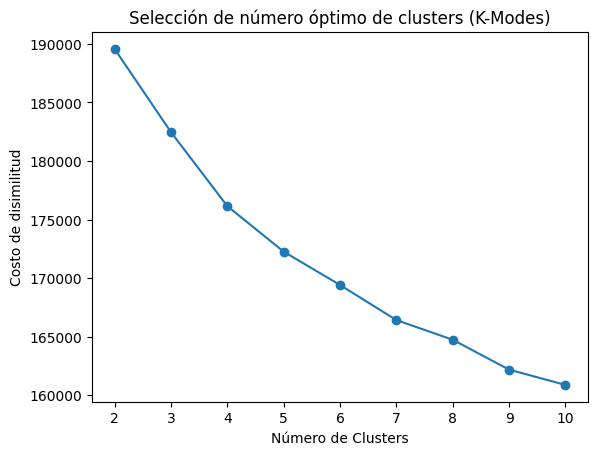

In [ ]:
# Metodo codo para identificar cantidad de clusters
# ==============================================================================

costs = []
K = range(2, 11)
for k in K:
    km = KModes(n_clusters=k, init='Huang', n_init=5, verbose=0)
    km.fit_predict(df.drop(columns=['latitud', 'longitud']))
    print(k)
    costs.append(km.cost_)

plt.plot(K, costs, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Costo de disimilitud')
plt.title('Selección de número óptimo de clusters (K-Modes)')
plt.show()

In [9]:
# Modelado
# ==============================================================================

# Kluster
k_optimo = 10
kmodes_final = KModes(n_clusters=k_optimo, init='Huang', n_init=10, verbose=1, random_state= 42)
df['cluster'] = kmodes_final.fit_predict(df.drop(columns=['latitud', 'longitud']))

# Análisis de los clusters
cluster_summary = df.groupby('cluster').mean()

print("Resumen por cluster:")
print(cluster_summary)


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 11452, cost: 163217.0
Run 1, iteration: 2/100, moves: 1507, cost: 163217.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 6533, cost: 160359.0
Run 2, iteration: 2/100, moves: 346, cost: 160359.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 10486, cost: 162188.0
Run 3, iteration: 2/100, moves: 2907, cost: 162048.0
Run 3, iteration: 3/100, moves: 226, cost: 162048.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 7433, cost: 165732.0
Run 4, iteration: 2/100, moves: 1458, cost: 165643.0
Run 4, iteration: 3/100, moves: 22, cost: 165643.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 11480, cost: 162776.0
Run 5, iteration: 

In [ ]:
# visualizacion
# ==============================================================================


df_dots = df[["latitud", "longitud", "cluster"]]

#df_dots[["latitud", "longitud"]]  = scaler.inverse_transform(df_dots[["latitud", "longitud"]])

# Crear mapa interactivo
mapa = folium.Map(location=[6.2442, -75.5812], zoom_start=12)

# Obtener una lista de colores desde una paleta de Matplotlib
num_clusters = df_dots['cluster'].nunique()
colormap = plt.cm.get_cmap('tab10', num_clusters)

# Crear un diccionario que mapea cada número de clúster a un color hexadecimal
cluster_colors = {cluster: mcolors.rgb2hex(colormap(i)[:3]) for i, cluster in enumerate(df_dots['cluster'].unique())}

# Agregar TODOS los puntos de hurtos al mapa
for _, row in df_dots.iterrows():
    folium.CircleMarker(
        location=[row["latitud"], row["longitud"]],
        radius=1.5,  # Tamaño fijo del círculo
        color=cluster_colors[row['cluster']],
        fill=True,
        fill_color=cluster_colors[row['cluster']],
        fill_opacity=0.5
    ).add_to(mapa)

# Agregar leyenda
legend_html = """
{% macro html(this, kwargs) %}
<div style="
    position: fixed;
    bottom: 50px;
    left: 50px;
    width: 180px;
    height: auto;
    z-index:9999;
    font-size:14px;
    background-color: white;
    padding: 10px;
    border:2px solid grey;
    border-radius: 5px;
">
    <b>Clusters</b><br>
    """ + "".join([
        f'<i style="background:{color};width:10px;height:10px;display:inline-block;margin-right:5px"></i> Cluster {cluster}<br>'
        for cluster, color in cluster_colors.items()
    ]) + """
</div>
{% endmacro %}
"""

legend = MacroElement()
legend._template = Template(legend_html)
mapa.get_root().add_child(legend)

mapa





Output hidden; open in https://colab.research.google.com to view.

In [10]:
# Volver a valores originales para analisis
# ==============================================================================
var = df.columns.to_list()
var.remove('cluster')
cluster_summary = df.groupby('cluster').agg(lambda x: x.mode().iloc[0])

cluster_summary_decoded = cluster_summary.copy()
for col in cluster_summary_decoded.columns:
    if col in encoder:
        cluster_summary_decoded[col] = cluster_summary_decoded[col].round().astype(int)
        cluster_summary_decoded[col] = encoder[col].inverse_transform(cluster_summary_decoded[col])

cluster_summary_decoded['Cantidad'] = df.groupby('cluster').size()
var.append('Cantidad')
cluster_summary_decoded[var].reset_index()


,cluster,latitud,longitud,sexo,edad,estado_civil,conducta,modalidad,arma_medio,codigo_comuna,lugar,categoria_bien,día,mes,zona,rango_hora,Cantidad
0,0,6.214753,-75.581299,Hombre,32,en_relacion,Hurto a persona,violentos,Con_Arma,10,exteriores,alto_valor,11,7,Centro,Tarde,5315
1,1,6.246744,-75.582865,Hombre,32,soltero,Hurto a establecimiento comercial,no_violentos,Sin_arma,10,interiores,alto_valor,7,9,Centro,Tarde,4895
2,2,6.214985,-75.575978,Hombre,26,soltero,Hurto de moto,no_violentos,Sin_arma,10,exteriores,vehiculos,19,3,Centro,Noche,4261
3,3,6.257563,-75.597037,Hombre,29,soltero,Hurto a persona,violentos,Con_Arma,10,interiores,alto_valor,15,10,Centro,Noche,2793
4,4,6.248857,-75.566607,Mujer,32,en_relacion,Hurto a persona,no_violentos,Sin_arma,10,interiores,alto_valor,11,6,Centro,Mañana,3524
5,5,6.250141,-75.597475,Hombre,28,en_relacion,Hurto a persona,violentos,Con_Arma,12,exteriores,alto_valor,22,8,Zona Norte,Noche,863
6,6,6.249775,-75.568542,Hombre,19,soltero,Hurto a persona,violentos,Con_Arma,10,exteriores,alto_valor,3,3,Centro,Noche,2686
7,7,6.250209,-75.567513,Hombre,30,soltero,Hurto a persona,violentos,Con_Arma,10,exteriores,alto_valor,27,2,Centro,Tarde,1759
8,8,6.188859,-75.606927,Mujer,32,soltero,Hurto a persona,violentos,Con_Arma,11,interiores,alto_valor,15,3,Centro,Noche,1489
9,9,6.228595,-75.585456,Mujer,58,soltero,Hurto a persona,no_violentos,Sin_arma,14,interiores,alto_valor,7,4,Centro,Mañana,2415


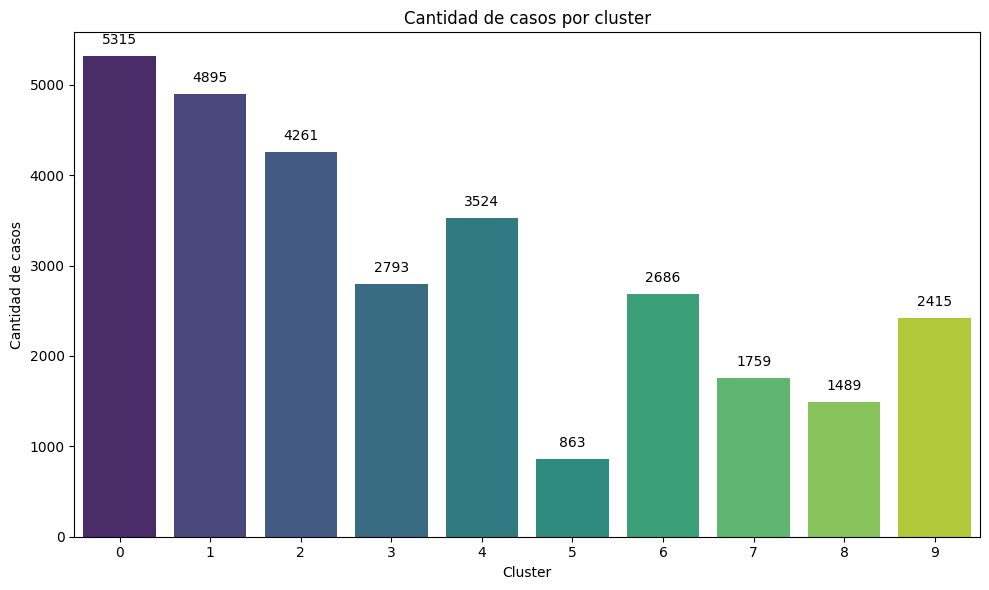

In [11]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=cluster_summary_decoded,
    x='cluster',
    y='Cantidad',
    palette='viridis'
)

# Agregar etiquetas de texto encima de las barras
for index, row in cluster_summary_decoded.reset_index().iterrows():
    plt.text(row['cluster'], row['Cantidad'] + 100, str(row['Cantidad']), ha='center', va='bottom')

# Etiquetas
plt.title("Cantidad de casos por cluster")
plt.xlabel("Cluster")
plt.ylabel("Cantidad de casos")
plt.xticks(rotation=0)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

# **Modelo con normalizados**


In [12]:
df_norm = pd.read_csv('/content/drive/MyDrive/Monografia Especializacion/Datasets/hurtos_normalize.csv')
scaler = joblib.load('/content/drive/MyDrive/Monografia Especializacion/Models/standard_scaler.pkl')
df_norm.info()
df_norm = df_norm.sample(n=8000, random_state=42)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 492988 entries, 0 to 492987
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   latitud         492988 non-null  float64
 1   longitud        492988 non-null  float64
 2   sexo            492988 non-null  float64
 3   edad            492988 non-null  float64
 4   estado_civil    492988 non-null  float64
 5   conducta        492988 non-null  float64
 6   modalidad       492988 non-null  float64
 7   arma_medio      492988 non-null  float64
 8   codigo_comuna   492988 non-null  float64
 9   lugar           492988 non-null  float64
 10  categoria_bien  492988 non-null  float64
 11  día             492988 non-null  float64
 12  mes             492988 non-null  float64
 13  zona            492988 non-null  float64
 14  rango_hora      492988 non-null  float64
dtypes: float64(15)
memory usage: 56.4 MB


2
3
4
5
6
7
8
9
10


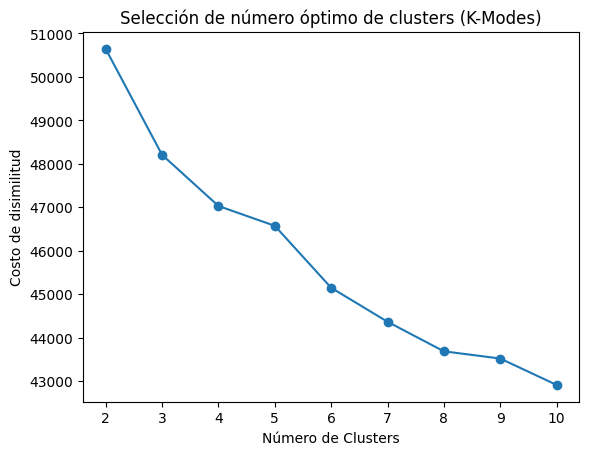

In [ ]:

# Metodo codo para identificar cantidad de clusters
# ==============================================================================

costs = []
K = range(2, 11)
for k in K:
    km = KModes(n_clusters=k, init='Huang', n_init=5, verbose=0)
    km.fit_predict(df_norm.drop(columns=['latitud', 'longitud']))
    print(k)
    costs.append(km.cost_)

plt.plot(K, costs, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Costo de disimilitud')
plt.title('Selección de número óptimo de clusters (K-Modes)')
plt.show()

In [13]:
# Modelado
# ==============================================================================

# Kluster
k_optimo = 8
kmodes_final = KModes(n_clusters=k_optimo, init='Huang', n_init=10, verbose=1, random_state= 42)
columns = df_norm.columns
df_norm['cluster'] = kmodes_final.fit_predict(df_norm.drop(columns=['latitud', 'longitud']))

# Análisis de los clusters
cluster_summary = df_norm.groupby('cluster').mean()

print("Resumen por cluster:")
print(cluster_summary)


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1971, cost: 44518.0
Run 1, iteration: 2/100, moves: 575, cost: 44518.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 2445, cost: 44318.0
Run 2, iteration: 2/100, moves: 1241, cost: 44001.0
Run 2, iteration: 3/100, moves: 335, cost: 44001.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 2880, cost: 45093.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 2464, cost: 44122.0
Run 4, iteration: 2/100, moves: 1537, cost: 43922.0
Run 4, iteration: 3/100, moves: 83, cost: 43922.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 3024, cost: 44137.0
Run 5, iteration: 2/100, moves: 379, cost: 44122.0
Run 5, iteration: 3/100, moves: 1

In [ ]:
# visualizacion
# ==============================================================================


df_dots = df_norm

df_dots[columns]  = scaler.inverse_transform(df_dots[columns])

# Crear mapa interactivo
mapa = folium.Map(location=[6.2442, -75.5812], zoom_start=12)

# Obtener una lista de colores desde una paleta de Matplotlib
num_clusters = df_dots['cluster'].nunique()
colormap = plt.cm.get_cmap('tab10', num_clusters)

# Crear un diccionario que mapea cada número de clúster a un color hexadecimal
cluster_colors = {cluster: mcolors.rgb2hex(colormap(i)[:3]) for i, cluster in enumerate(df_dots['cluster'].unique())}

# Agregar TODOS los puntos de hurtos al mapa
for _, row in df_dots.iterrows():
    folium.CircleMarker(
        location=[row["latitud"], row["longitud"]],
        radius=1.5,  # Tamaño fijo del círculo
        color=cluster_colors[row['cluster']],
        fill=True,
        fill_color=cluster_colors[row['cluster']],
        fill_opacity=0.5
    ).add_to(mapa)

# Agregar leyenda
legend_html = """
{% macro html(this, kwargs) %}
<div style="
    position: fixed;
    bottom: 50px;
    left: 50px;
    width: 180px;
    height: auto;
    z-index:9999;
    font-size:14px;
    background-color: white;
    padding: 10px;
    border:2px solid grey;
    border-radius: 5px;
">
    <b>Clusters</b><br>
    """ + "".join([
        f'<i style="background:{color};width:10px;height:10px;display:inline-block;margin-right:5px"></i> Cluster {cluster}<br>'
        for cluster, color in cluster_colors.items()
    ]) + """
</div>
{% endmacro %}
"""

legend = MacroElement()
legend._template = Template(legend_html)
mapa.get_root().add_child(legend)


mapa




Output hidden; open in https://colab.research.google.com to view.

In [14]:
var = df_norm.columns.to_list()
var.remove('cluster')

df_norm[var]  = scaler.inverse_transform(df_norm[var])

cluster_summary = df_norm.groupby('cluster').agg(lambda x: x.mode().iloc[0])

cluster_summary_decoded = cluster_summary.copy()
for col in cluster_summary_decoded.columns:
    if col in encoder:
        cluster_summary_decoded[col] = cluster_summary_decoded[col].round().astype(int)
        cluster_summary_decoded[col] = encoder[col].inverse_transform(cluster_summary_decoded[col])

cluster_summary_decoded['Cantidad'] = df_norm.groupby('cluster').size()
var.append('Cantidad')
cluster_summary_decoded[var].reset_index()

,cluster,latitud,longitud,sexo,edad,estado_civil,conducta,modalidad,arma_medio,codigo_comuna,lugar,categoria_bien,día,mes,zona,rango_hora,Cantidad
0,0,6.245890,-75.574570,Hombre,58.0,soltero,Hurto a persona,no_violentos,Sin_arma,10.0,exteriores,alto_valor,16.0,2.0,Centro,Madrugada,1202
1,1,6.202870,-75.607716,Hombre,30.0,soltero,Hurto a persona,violentos,Con_Arma,11.0,interiores,alto_valor,29.0,7.0,Centro,Madrugada,1148
2,2,6.249980,-75.566315,Hombre,32.0,soltero,Hurto a persona,violentos,Con_Arma,10.0,exteriores,alto_valor,2.0,10.0,Centro,Tarde,1602
3,3,6.168263,-75.608642,Mujer,32.0,soltero,Hurto a persona,no_violentos,Sin_arma,14.0,interiores,alto_valor,28.0,6.0,Centro,Mañana,1255
4,4,6.214985,-75.600141,Hombre,32.0,soltero,Hurto de moto,no_violentos,Sin_arma,4.0,exteriores,vehiculos,10.0,11.0,Centro,Noche,1030
5,5,6.248580,-75.583152,Hombre,22.0,soltero,Hurto a persona,violentos,Con_Arma,10.0,exteriores,alto_valor,12.0,3.0,Centro,Mañana,671
6,6,6.217438,-75.593566,Hombre,58.0,soltero,Hurto a persona,no_violentos,Sin_arma,10.0,interiores,alto_valor,18.0,7.0,Centro,Mañana,581
7,7,6.187137,-75.614953,Hombre,32.0,en_relacion,Hurto a establecimiento comercial,no_violentos,Con_Arma,14.0,interiores,alto_valor,2.0,4.0,Centro,Noche,511


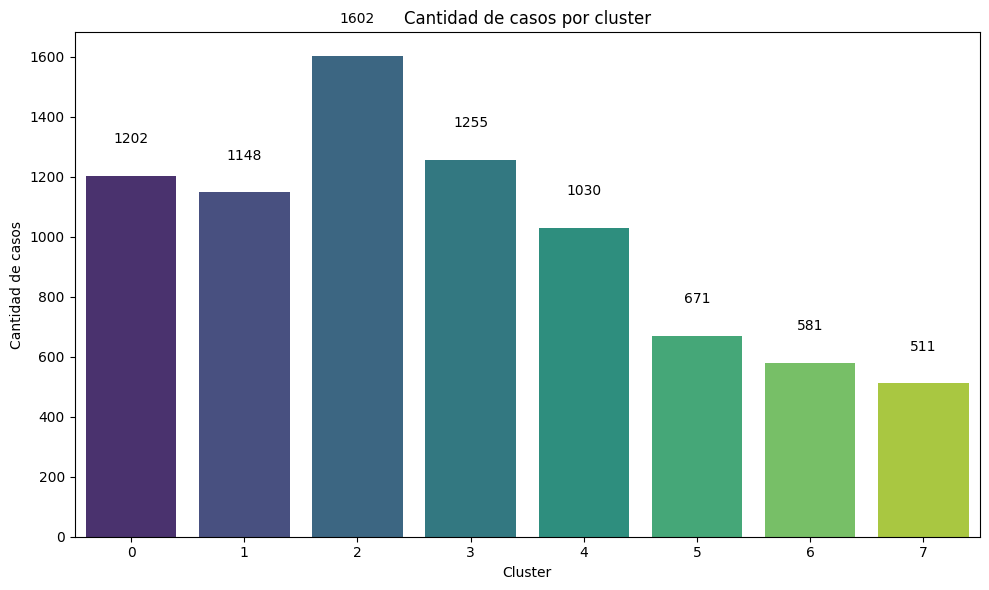

In [15]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=cluster_summary_decoded,
    x='cluster',
    y='Cantidad',
    palette='viridis'
)

# Agregar etiquetas de texto encima de las barras
for index, row in cluster_summary_decoded.reset_index().iterrows():
    plt.text(row['cluster'], row['Cantidad'] + 100, str(row['Cantidad']), ha='center', va='bottom')

# Etiquetas
plt.title("Cantidad de casos por cluster")
plt.xlabel("Cluster")
plt.ylabel("Cantidad de casos")
plt.xticks(rotation=0)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

# **Reduccion de dimensionalidad**

In [16]:
df_reduc = pd.read_csv('/content/drive/MyDrive/Monografia Especializacion/Datasets/hurtos_normalize.csv')
df_reduc = df_reduc.sample(n=10000, random_state=42)

In [17]:
# Kernel pca
# ==============================================================================
X = df_reduc.values

kernel_pca = KernelPCA(
    n_components=5, kernel="rbf", gamma=0.1
)
X_test_kernel_pca = kernel_pca.fit_transform(X)

# Crear DataFrame de los componentes reducidos
df_kernel_pca = pd.DataFrame(
    X_test_kernel_pca,
    columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'],
    index=df_reduc.iloc[X_test_kernel_pca.shape[0]*-1:].index
)

# Crear DataFrame original de test
df_test_original = pd.DataFrame(X, columns=df_reduc.columns)

# Concatenar
df_combined = pd.concat([df_test_original.reset_index(drop=True), df_kernel_pca.reset_index(drop=True)], axis=1)

df_combined.head()



,latitud,longitud,sexo,edad,estado_civil,conducta,modalidad,arma_medio,codigo_comuna,lugar,categoria_bien,día,mes,zona,rango_hora,PC1,PC2,PC3,PC4,PC5
0,1.136700,0.005946,1.302668,-0.215400,0.776534,-1.263604,1.031051,-1.013972,-1.005474,1.069119,0.613005,-1.083053,0.374026,-0.545270,-0.599263,0.111223,-0.096248,-0.034838,0.158547,0.132632
1,1.524584,0.008360,1.302668,0.063861,0.776534,-0.437851,1.031051,-1.013972,-0.824828,-0.935349,-0.600282,1.636618,-1.650185,1.512197,-1.527258,0.089186,0.050357,0.028643,0.160094,0.168741
2,-0.580780,0.103102,-0.767655,0.436207,-1.287774,1.213655,-0.969885,0.986220,-0.282890,-0.935349,1.826292,-1.083053,-0.782666,-0.545270,0.328733,-0.181407,0.374321,0.005134,-0.105530,-0.159018
3,-1.109915,0.013558,1.302668,-0.215400,-1.287774,-1.263604,1.031051,-1.013972,0.620340,1.069119,0.613005,-1.309693,0.663199,-0.545270,-0.599263,0.044181,-0.063687,0.203178,0.122674,0.117824
4,0.035527,0.064806,-0.767655,-0.122313,-1.287774,1.213655,-0.969885,0.986220,-0.463536,1.069119,1.826292,-1.536332,-0.204320,-0.545270,-1.527258,-0.223359,0.253834,0.005975,-0.122659,0.072195


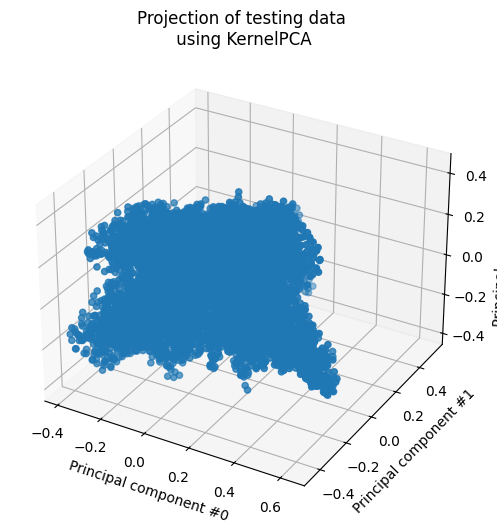

In [ ]:
fig = plt.figure(figsize=(10, 6))
kernel_pca_proj_ax = fig.add_subplot(111, projection='3d')  # Activa el modo 3D

# Grafica en 3D usando los tres primeros componentes principales
kernel_pca_proj_ax.scatter(
    X_test_kernel_pca[:, 0],
    X_test_kernel_pca[:, 1],
    X_test_kernel_pca[:, 2],
    cmap="viridis"
)

# Etiquetas de los ejes
kernel_pca_proj_ax.set_xlabel("Principal component #0")
kernel_pca_proj_ax.set_ylabel("Principal component #1")
kernel_pca_proj_ax.set_zlabel("Principal component #2")
kernel_pca_proj_ax.set_title("Projection of testing data\n using KernelPCA")

plt.show()

2
3
4
5
6
7
8
9
10


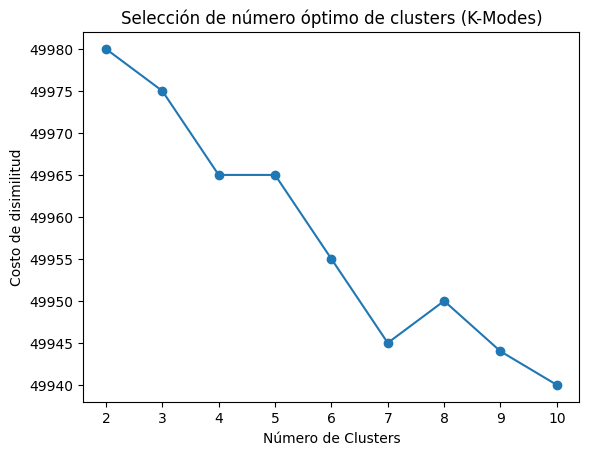

In [18]:
# Metodo codo para identificar cantidad de clusters
# ==============================================================================

costs = []
K = range(2, 11)
for k in K:
    km = KModes(n_clusters=k, init='Huang', n_init=5, verbose=0)
    km.fit_predict(X_test_kernel_pca)
    print(k)
    costs.append(km.cost_)

plt.plot(K, costs, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Costo de disimilitud')
plt.title('Selección de número óptimo de clusters (K-Modes)')
plt.show()

In [19]:
# Modelado
# ==============================================================================

df_kernel = pd.DataFrame(X_test_kernel_pca, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
# Kluster
k_optimo = 8
kmodes_final = KModes(n_clusters=k_optimo, init='Huang', n_init=10, verbose=1, random_state= 42)
columns = df_kernel.columns
df_combined['cluster'] = kmodes_final.fit_predict(df_kernel)

# Análisis de los clusters
cluster_summary = df_combined.groupby('cluster').mean()

print("Resumen por cluster:")
print(cluster_summary)


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 49950.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 49950.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 49945.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 49950.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 49950.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 6, iteration: 1/100, moves: 0, cost: 49945.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 7, iteration: 1/100, moves: 0, cost: 49950.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 8, iteration:

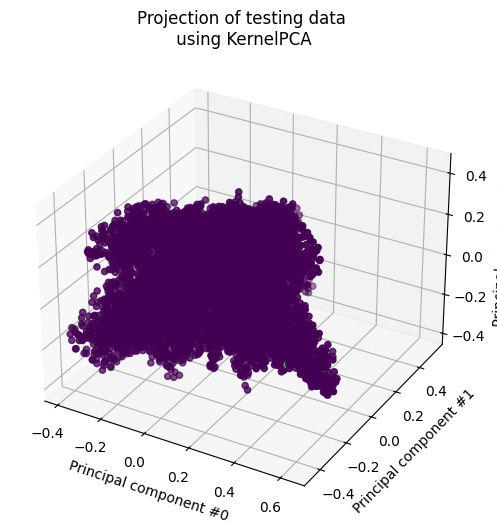

In [ ]:
fig = plt.figure(figsize=(10, 6))
kernel_pca_proj_ax = fig.add_subplot(111, projection='3d')  # Activa el modo 3D

# Grafica en 3D usando los tres primeros componentes principales
kernel_pca_proj_ax.scatter(
    df_combined['PC1'],
    df_combined['PC2'],
    df_combined['PC3'],
    c = df_combined['cluster'],
    cmap="viridis"
)

# Etiquetas de los ejes
kernel_pca_proj_ax.set_xlabel("Principal component #0")
kernel_pca_proj_ax.set_ylabel("Principal component #1")
kernel_pca_proj_ax.set_zlabel("Principal component #2")
kernel_pca_proj_ax.set_title("Projection of testing data\n using KernelPCA")

plt.show()

In [ ]:
# visualizacion
# ==============================================================================

df_dots = df_combined.copy()
df_dots.drop(columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'], inplace=True)
columns = [col for col in df_dots.columns if col != 'cluster']

df_dots[columns]  = scaler.inverse_transform(df_dots[columns])

# Crear mapa interactivo
mapa = folium.Map(location=[6.2442, -75.5812], zoom_start=12)

# Obtener una lista de colores desde una paleta de Matplotlib
num_clusters = df_dots['cluster'].nunique()
colormap = plt.cm.get_cmap('tab10', num_clusters)

# Crear un diccionario que mapea cada número de clúster a un color hexadecimal
cluster_colors = {cluster: mcolors.rgb2hex(colormap(i)[:3]) for i, cluster in enumerate(df_dots['cluster'].unique())}

# Agregar TODOS los puntos de hurtos al mapa
for _, row in df_dots.iterrows():
    folium.CircleMarker(
        location=[row["latitud"], row["longitud"]],
        radius=1.5,  # Tamaño fijo del círculo
        color=cluster_colors[row['cluster']],
        fill=True,
        fill_color=cluster_colors[row['cluster']],
        fill_opacity=0.5
    ).add_to(mapa)


# Agregar leyenda
legend_html = """
{% macro html(this, kwargs) %}
<div style="
    position: fixed;
    bottom: 50px;
    left: 50px;
    width: 180px;
    height: auto;
    z-index:9999;
    font-size:14px;
    background-color: white;
    padding: 10px;
    border:2px solid grey;
    border-radius: 5px;
">
    <b>Clusters</b><br>
    """ + "".join([
        f'<i style="background:{color};width:10px;height:10px;display:inline-block;margin-right:5px"></i> Cluster {cluster}<br>'
        for cluster, color in cluster_colors.items()
    ]) + """
</div>
{% endmacro %}
"""

legend = MacroElement()
legend._template = Template(legend_html)
mapa.get_root().add_child(legend)


mapa




Output hidden; open in https://colab.research.google.com to view.

In [21]:
var = df_combined.columns.to_list()
var.remove('cluster')
var.remove('PC1')
var.remove('PC2')
var.remove('PC3')
var.remove('PC4')
var.remove('PC5')
df_combined[var]  = scaler.inverse_transform(df_combined[var])

cluster_summary = df_combined.groupby('cluster').agg(lambda x: x.mode().iloc[0])

cluster_summary_decoded = cluster_summary.copy()
for col in cluster_summary_decoded.columns:
    if col in encoder:
        cluster_summary_decoded[col] = cluster_summary_decoded[col].round().astype(int)
        cluster_summary_decoded[col] = encoder[col].inverse_transform(cluster_summary_decoded[col])

cluster_summary_decoded['Cantidad'] = df_combined.groupby('cluster').size()
var.append('Cantidad')
cluster_summary_decoded[var].reset_index()

,cluster,latitud,longitud,sexo,edad,estado_civil,conducta,modalidad,arma_medio,codigo_comuna,lugar,categoria_bien,día,mes,zona,rango_hora,Cantidad
0,0,6.249775,-75.568542,Hombre,32.0,soltero,Hurto a persona,no_violentos,Sin_arma,10.0,exteriores,alto_valor,2.0,8.0,Centro,Tarde,9991
1,1,6.241677,-75.586983,Hombre,32.0,en_relacion,Hurto a establecimiento comercial,no_violentos,Sin_arma,11.0,interiores,alto_valor,23.0,1.0,Centro,Tarde,1
2,2,6.296028,-75.581680,Mujer,32.0,soltero,Hurto a establecimiento comercial,violentos,Sin_arma,6.0,exteriores,alto_valor,21.0,2.0,Centro,Mañana,1
3,3,6.260186,-75.579854,Mujer,32.0,en_relacion,Hurto a establecimiento comercial,no_violentos,Sin_arma,7.0,exteriores,materiales,2.0,6.0,Centro,Madrugada,1
4,4,6.305367,-75.575056,Mujer,43.0,en_relacion,Hurto a residencia,no_violentos,Sin_arma,6.0,interiores,alto_valor,29.0,5.0,Centro,Tarde,1
5,5,6.258994,-75.558832,Mujer,28.0,soltero,Hurto a persona,violentos,Con_Arma,10.0,exteriores,alto_valor,18.0,9.0,Centro,Noche,1
6,6,6.230156,-75.529875,Hombre,58.0,soltero,Hurto a residencia,no_violentos,Sin_arma,9.0,interiores,alto_valor,6.0,9.0,Centro,Noche,3
7,7,6.239632,-75.559085,Hombre,35.0,en_relacion,Hurto de carro,no_violentos,Sin_arma,9.0,exteriores,vehiculos,2.0,7.0,Centro,Mañana,1


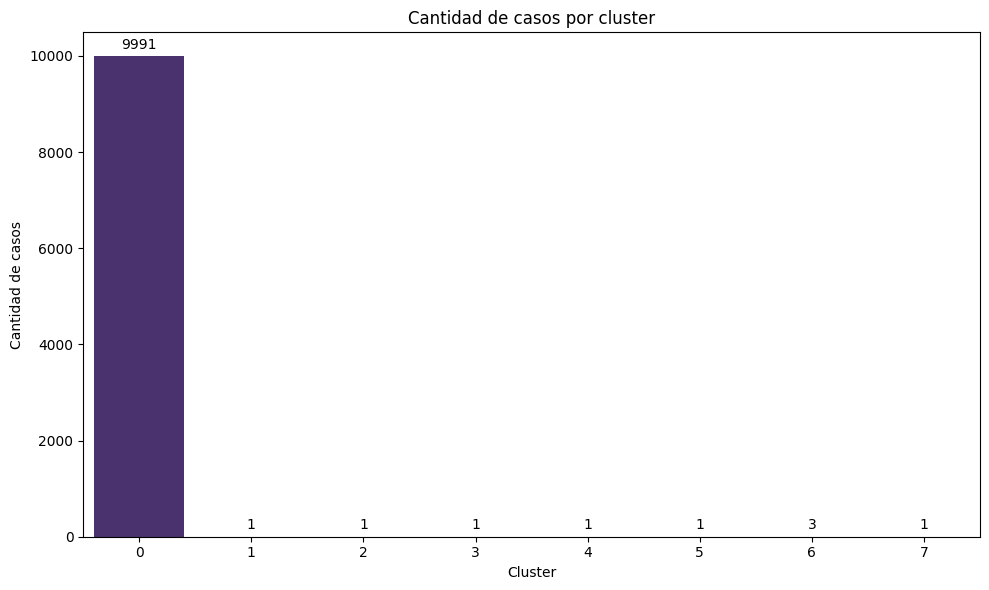

In [22]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=cluster_summary_decoded,
    x='cluster',
    y='Cantidad',
    palette='viridis'
)

# Agregar etiquetas de texto encima de las barras
for index, row in cluster_summary_decoded.reset_index().iterrows():
    plt.text(row['cluster'], row['Cantidad'] + 100, str(row['Cantidad']), ha='center', va='bottom')

# Etiquetas
plt.title("Cantidad de casos por cluster")
plt.xlabel("Cluster")
plt.ylabel("Cantidad de casos")
plt.xticks(rotation=0)

# Mostrar el gráfico
plt.tight_layout()
plt.show()